In [ ]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
# Valeria Quiroz  - Gabriel Zapata
%%time
!pip install kaggle
api_token = {"username":"gabrielzapata","key":"45d11139cb4e32995898eae373213b5f"}
import json
import zipfile
import os
with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mkdir /root/.kaggle      
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction
if not os.path.exists("/content/competitions/ga-customer-revenue-prediction"):
    os.makedirs("/content/competitions/ga-customer-revenue-prediction")
os.chdir('/content/competitions/ga-customer-revenue-prediction')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

- path is now set to: /content
 99% 1.10G/1.11G [00:09<00:00, 116MB/s]
100% 1.11G/1.11G [00:09<00:00, 129MB/s]
  0% 0.00/5.23M [00:00<?, ?B/s]
100% 5.23M/5.23M [00:00<00:00, 86.1MB/s]
 85% 52.0M/61.1M [00:00<00:00, 83.4MB/s]
100% 61.1M/61.1M [00:00<00:00, 113MB/s] 
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 174MB/s]
 77% 44.0M/56.8M [00:00<00:00, 74.1MB/s]
100% 56.8M/56.8M [00:00<00:00, 116MB/s] 
 96% 320M/333M [00:02<00:00, 147MB/s]
100% 333M/333M [00:02<00:00, 120MB/s]
CPU times: user 1min 52s, sys: 39.3 s, total: 2min 31s
Wall time: 7min 38s


### **Librerias**

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas import json_normalize
import seaborn as sns 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import datetime
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold, RepeatedKFold
from sklearn.pipeline import Pipeline
#from sklearn.metrics import mean_absolute_percentage_error

### **Explicacion del codigo json sacado de Kaggle, para aplanar los datos**

In [ ]:
def load_df(csv_path='/content/competitions/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
%%time
train_df = load_df()
#test_df = load_df('/content/competitions/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 12s, sys: 11.3 s, total: 2min 23s
Wall time: 2min 37s


In [ ]:
train_df = train_df.drop( ['sessionId'] + ["trafficSource.campaignCode"], axis=1)
print(train_df.shape)

(903653, 53)


### **Eliminemos columnas constantes e imputar valores cero a NAN**

In [ ]:
print ("Antes de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
print ("Despues de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)

Antes de eliminar columnas constantes - shape de train y test datasets:  (903653, 53)
Despues de eliminar columnas constantes - shape de train y test datasets:  (903653, 34)


In [ ]:
# Replace NaN values throughout train dataset
train_df.replace(to_replace=np.nan, value=0, inplace=True)

### **Conversion variable categórica a númerica**

In [ ]:
# etiqueta codifica las variables categóricas y convierte las variables numéricas flotantes
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", "device.isMobile",
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
   

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
device.isMobile
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
train_df.to_csv('dataset.csv')

In [ ]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))###Cambia el formato de la fecha

In [ ]:
Y = train_df["totals.transactionRevenue"].astype('float')
X=train_df.drop(["totals.transactionRevenue"],axis=1)##Eliminamos la salida de los datos de las caracteristicas


In [ ]:
##==================###Fold1######============================
Fold1 = train_df[train_df['date']<=datetime.date(2016,11,1)]
train1=Fold1[Fold1['date']<=datetime.date(2016,9,15)]
Val1=Fold1[Fold1['date']>datetime.date(2016,9,15)]

##==================###Fold2######============================
Foldt = train_df[train_df['date']>datetime.date(2016,11,1)]
Fold2 = Foldt[Foldt['date']<=datetime.date(2017,2,1)]
train2=Fold2[Fold2['date']<=datetime.date(2016,12,15)]
Val2=Fold2[Fold2['date']>datetime.date(2016,12,15)]

##==================###Fold3######============================
Foldt2 = train_df[train_df['date']>datetime.date(2017,2,1)]
Fold3 = Foldt2[Foldt2['date']<=datetime.date(2017,5,1)]
train3=Fold3[Fold3['date']<=datetime.date(2017,3,15)]
Val3=Fold3[Fold3['date']>datetime.date(2017,3,15)]

##===================#####All Train#######====================
X_Train=train_df[train_df['date']<=datetime.date(2017,5,1)]
Y_Train=np.log1p(X_Train["totals.transactionRevenue"].astype('float'))

##======================####Test#####==========================
Test = train_df[train_df['date']>datetime.date(2017,5,1)]
y_test= np.log1p(Test["totals.transactionRevenue"].astype('float'))
X_test=Test.drop(["totals.transactionRevenue"],axis=1)

In [ ]:
dev_y1 = np.log1p(train1["totals.transactionRevenue"].astype('float'))
val_y1 = np.log1p(Val1["totals.transactionRevenue"].astype('float'))
dev_y2 = np.log1p(train2["totals.transactionRevenue"].astype('float'))
val_y2 = np.log1p(Val2["totals.transactionRevenue"].astype('float'))
dev_y3 = np.log1p(train3["totals.transactionRevenue"].astype('float'))
val_y3 = np.log1p(Val3["totals.transactionRevenue"].astype('float'))

In [ ]:
X_Train=X_Train.drop(["totals.transactionRevenue"],axis=1)
train1=train1.drop(["totals.transactionRevenue"],axis=1)
train2=train2.drop(["totals.transactionRevenue"],axis=1)
train3=train3.drop(["totals.transactionRevenue"],axis=1)
Val1=Val1.drop(["totals.transactionRevenue"],axis=1)
Val2=Val2.drop(["totals.transactionRevenue"],axis=1)
Val3=Val3.drop(["totals.transactionRevenue"],axis=1)

In [ ]:
X_Train=X_Train.drop(["date"],axis=1)
train1=train1.drop(["date"],axis=1)
train2=train2.drop(["date"],axis=1)
train3=train3.drop(["date"],axis=1)
Val1=Val1.drop(["date"],axis=1)
Val2=Val2.drop(["date"],axis=1)
Val3=Val3.drop(["date"],axis=1)
X_test=X_test.drop(["date"],axis=1)

Graficas Experimento GBT

In [ ]:
from sklearn import tree

BestModelMAE1= GradientBoostingRegressor(n_estimators=80,max_depth =3)##MAE
BestModelMAE1.fit(X_Train,Y_Train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=80,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

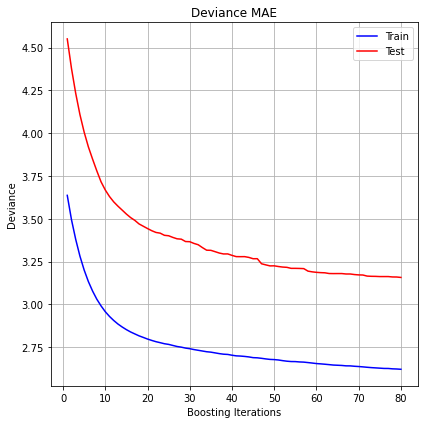

In [ ]:
test_score = np.zeros(80)
for i, y_pred in enumerate(BestModelMAE1.staged_predict(X_test)):
    test_score[i] = BestModelMAE1.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance MAE')
plt.plot(np.arange(80) + 1, BestModelMAE1.train_score_, 'b-',
         label='Train')
plt.plot(np.arange(80) + 1, test_score, 'r-',
         label='Test')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.grid()
plt.show()

In [ ]:
BestModelMSE1= GradientBoostingRegressor(n_estimators=90,max_depth =3)
BestModelMSE1.fit(X_Train,Y_Train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=90,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

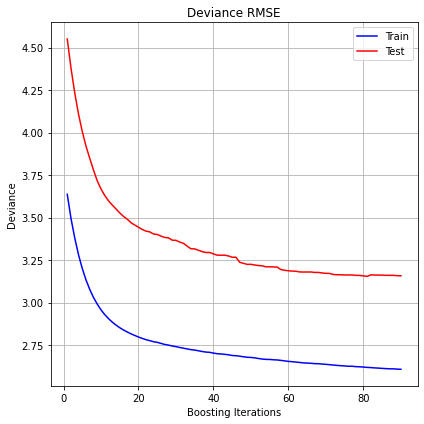

In [ ]:
test_score = np.zeros(90)
for i, y_pred in enumerate(BestModelMSE1.staged_predict(X_test)):
    test_score[i] = BestModelMSE1.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance RMSE')
plt.plot(np.arange(90) + 1, BestModelMSE1.train_score_, 'b-',
         label='Train')
plt.plot(np.arange(90) + 1, test_score, 'r-',
         label='Test')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.grid()
plt.show()

In [ ]:
test_score = np.zeros(90)
for i, y_pred in enumerate(BestModelMSE1.staged_predict(X_test)):
    test_score[i] = BestModelMSE1.loss_(y_test, y_pred)
print(test_score)

[4.55089225 4.37852554 4.2331226  4.10894949 4.00640254 3.92015514
 3.84829411 3.77976633 3.71609268 3.66844473 3.63009667 3.5989014
 3.57382344 3.55087345 3.52765273 3.50712848 3.49076039 3.46996655
 3.45651445 3.44318372 3.43050003 3.42032284 3.41616095 3.40356273
 3.40097513 3.39127863 3.38315387 3.38099778 3.3672253  3.36622708
 3.35609968 3.34852504 3.33174972 3.31664111 3.31579098 3.30799771
 3.29995156 3.29462297 3.29484708 3.2863859  3.27911076 3.27875334
 3.27895776 3.27445002 3.26676905 3.26692407 3.23724296 3.23087844
 3.22488565 3.22526855 3.22123655 3.2180331  3.21648574 3.21054521
 3.2105455  3.20997864 3.20896651 3.19427535 3.1900952  3.18722308
 3.18548225 3.18448048 3.18034238 3.17992622 3.18009076 3.18009124
 3.17758951 3.17758944 3.17425237 3.17227984 3.17157824 3.16530661
 3.16407118 3.16367841 3.16253695 3.16256152 3.16256134 3.16026957
 3.15994587 3.15737593 3.15427391 3.16335189 3.16218091 3.16194971
 3.16155472 3.16045733 3.16029691 3.16029654 3.15819328 3.15803

In [ ]:
enumerate(BestModelMSE1.staged_predict(X_test))

Graficas Experimento RF

In [ ]:
BestModelMAE1RF= RandomForestRegressor(n_estimators=20,max_depth =3,oob_score=True)
BestModelMAE1RF.fit(X_Train,Y_Train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
BestModelMAE1RF.oob_score_

0.24360464325000541